In [1]:
from importnb import Notebook
with Notebook():
    import news_analysis
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import pickle
from glob import glob
import re
from copy import deepcopy
from pathos.multiprocessing import Pool
from tqdm import tqdm_notebook

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn.metrics as metrics
from xgboost import XGBRegressor, XGBClassifier
import hyperopt
from hyperopt import hp

import statsmodels.formula.api as smf

In [2]:
PATH_TO_DATA = 'data/news_models/'

#### Metrics

In [3]:
def accuracy(y_true, y_pred):
    return metrics.accuracy_score(y_true, y_pred)

def precision(y_true, y_pred): # price up is positive if not down
    return metrics.precision_score(y_true, y_pred)

def recall(y_true, y_pred, down=False): # price up is positive if not down
    return metrics.recall_score(y_true, y_pred)

def f1_score(y_true, y_pred, down=False): # price up is positive if not down
    return metrics.f1_score(y_true, y_pred)
    
def summary(y_true, y_pred):
    l = []
    l.append('Acc: ' + str(accuracy(y_true, y_pred)))
    l.append('Precison: ' + str(precision(y_true, y_pred)))
    l.append('Recall: ' + str(recall(y_true, y_pred)))
    l.append('F1: ' + str(f1_score(y_true, y_pred)))
    l.append('Confusion matrix:')
    print('\n'.join(l))
    print(pd.DataFrame(metrics.confusion_matrix(y_true, y_pred, labels=[0,1]), columns=['0', '1'], index=['0', '1']))

#### Downloading database from server

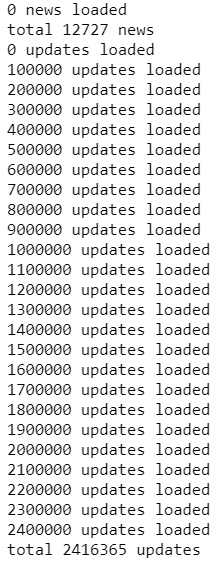

#### Saving latest DB as DataFrame

#### Loading latest DataFrame

In [4]:
df_news_paths = glob(PATH_TO_DATA+'dfnews*.pkl')
df_votes_paths = glob(PATH_TO_DATA+'dfvotes*.pkl')

df_news_dates = np.array([datetime.datetime.strptime(
                                re.findall(pattern='([0-9]{8}T[0-9]{4})', string=path)[0], '%Y%m%dT%H%M') 
                         for path in df_news_paths])
df_votes_dates = np.array([datetime.datetime.strptime(
                                re.findall(pattern='([0-9]{8}T[0-9]{4})', string=path)[0], '%Y%m%dT%H%M') 
                         for path in df_votes_paths])

last_df_news = PATH_TO_DATA+'dfnews'+df_news_dates.max().strftime("%Y%m%dT%H%M")+'.pkl'
last_df_votes = PATH_TO_DATA+'dfvotes'+df_votes_dates.max().strftime("%Y%m%dT%H%M")+'.pkl'

df_news, df_votes = news_analysis.load_news_and_votes(file_news=last_df_news,file_votes=last_df_votes)
df_news.sort_values(by='created_at', inplace=True)

#### Downloading prices

#### Loading latest prices

In [5]:
df_prices = pd.read_csv(PATH_TO_DATA+'prices.tmp')
df_prices.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,6598.033043,2018-10-04 10:25:00,6599.000000,6598.000000,6598.000000,5.824797,38432.098929,6598.015163
1,6597.375026,2018-10-04 10:30:00,6600.000000,6597.375026,6599.000000,0.325036,2145.124350,6599.656856
2,6596.309206,2018-10-04 10:35:00,6597.000000,6595.966957,6596.342241,2.402820,15850.999815,6596.831100
3,6586.387968,2018-10-04 10:40:00,6595.966957,6581.000000,6595.966957,8.190758,53909.105031,6581.699455
4,6591.733905,2018-10-04 10:45:00,6591.733905,6581.000000,6581.000000,13.092135,86171.349453,6581.917330


#### Drop latest news (with unknown future prices)

In [6]:
max_lag = 24*3600

dates = news_analysis.to_datetime(df_news.created_at.values)
prices_end = news_analysis.to_datetime(df_prices.date.iloc[-1:], '%Y-%m-%d %H:%M')[-1]
date_end = dates[dates < prices_end - datetime.timedelta(0, max_lag)][-1]
df_news = df_news.iloc[dates < prices_end - datetime.timedelta(0, max_lag)]

#### Drop latest votes updates (more than 4 hours after news was created)

#### Train test split

In [7]:
def df_train_test_split(df, test_share=0.3, test_size=None, test_indexes=None):
    if type(test_indexes) != type(None):
        train_indexes = np.array(list(set(np.arange(df.shape[0])).difference(test_indexes)))
        return df.iloc[train_indexes], df.iloc[test_indexes]
    elif type(test_size) != type(None):
        return df.iloc[:-test_size], df.iloc[-test_size:]
    else:
        train_size = int(df.shape[0] * (1 - test_share))
        return df_news.iloc[:train_size], df_news.iloc[train_size:]

In [8]:
df_news_train, df_news_test = df_train_test_split(df_news, test_share=0.3)

#### Doc2Vec model

In [9]:
class D2Vmodel:
    def __init__(self, vector_size=10, window=2, min_count=1, n_jobs=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.d2v_model = None
        self.n_jobs = n_jobs
    
    def fit_transform(self, texts):
        documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
        self.d2v_model = Doc2Vec(documents, 
                                 vector_size=self.vector_size, 
                                 window=self.window, 
                                 min_count=self.min_count, 
                                 workers=self.n_jobs)
        X = np.array([self.d2v_model.infer_vector(text) for text in texts])
        return X
    
    def transform(self, texts):
        X = np.array([self.d2v_model.infer_vector(text) for text in texts])
        return X

#### Create additional features (created_at diffs, hashtags, timestamp of created_at, price at created_at, price diff)

In [10]:
def make_features_additional(df_news, df_prices):
    df_feat = pd.DataFrame()
    dates = news_analysis.to_datetime(df_news.created_at.values)
    df_feat['time_diff'] = list(map(datetime.timedelta.total_seconds, dates[1:] - dates[:-1])) + [0]
    df_feat['timestamp'] = list(map(datetime.datetime.timestamp, dates))
    df_feat['price'] = news_analysis.get_prices_at_date(dates, df_prices)
    df_feat['price_diff_abs'] = np.concatenate((df_feat['price'].values[1:] - df_feat['price'].values[:-1], [0]))
    df_feat['price_diff_rel'] = np.concatenate((df_feat['price'].values[1:] / df_feat['price'].values[:-1] - 1, [0]))
#     df_feat.fillna(0, inplace=True)
    
    return df_feat

#### Create embeddings

In [11]:
def make_features_embeddings(df_news, d2v_fitted):
    embeddings = d2v_fitted.transform(df_news.title.values)
    df_feat = pd.DataFrame()
    for i in range(embeddings.shape[1]):
        df_feat['emb_'+str(i)] = embeddings[:,i]
    return df_feat

#### Create votes feature (last votes at time of last news in window)

In [12]:
def get_votes(df_news_slice, created_at_slice, date_modified_news_slice,
              df_votes, date_modified_votes):
    votes_columns = ['votes_lol', 'votes_toxic', 'votes_disliked', 'votes_negative', 'votes_saved',
                     'votes_liked','votes_positive', 'votes_important']
    votes = []
#     date_modified = []
    for i in range(df_news_slice.shape[0]):
        df_votes_current = df_votes[df_votes.id == df_news_slice.iloc[i].id]
        date_modified_votes_current = date_modified_votes[df_votes.id == df_news_slice.iloc[i].id]
        last_update = max(date_modified_votes[date_modified_votes <=  date_modified_news_slice[-1]])
        votes_current = df_votes_current[date_modified_votes_current == last_update].loc[:,
                    votes_columns].values
        if list(votes_current) != []:
            votes.append(votes_current[0])
#             date_modified.append(last_update)
        else:
            votes_current = df_news_slice.iloc[i,:]
            votes_current = votes_current.loc[votes_columns]
            votes.append(votes_current)
#             date_modified.append(date_modified_news_slice[i])
    
    return np.array(votes)#, date_modified

def make_features_votes(df_news, df_votes, window_width=10, window_stride=1):
    votes = []
    created_at = news_analysis.to_datetime(df_news.created_at.values)
    date_modified_news = news_analysis.to_datetime(df_news.date_modified.values, '%m/%d/%Y %H:%M')
    date_modified_votes = news_analysis.to_datetime(df_votes.date_modified.values, '%m/%d/%Y %H:%M')
    
    ids = df_votes.id.values
    ids_current = df_news.id.values[:window_width-window_stride]
    df_votes_current = pd.DataFrame()
    date_modified_votes_current = []
    for i in ids_current:
        df_votes_current = pd.concat([df_votes_current, df_votes[ids == i]])
        date_modified_votes_current = np.concatenate([date_modified_votes_current,
                                                      date_modified_votes[ids == i]])
    date_modified_feature = []
    for i in tqdm_notebook(range(window_width, df_news.shape[0]+1, window_stride)):
        start, end = i-window_width, i
        
        ids_current = df_news.id.values[start:end]
        for j in ids_current[-window_stride:]:
            df_votes_current = pd.concat([df_votes_current, df_votes[ids == j]])
            date_modified_votes_current = np.concatenate([date_modified_votes_current,
                                                      date_modified_votes[ids == j]])
        
        votes_current = get_votes(df_news[start:end], created_at[start:end], date_modified_news[start:end],
              df_votes_current, date_modified_votes_current)
        votes.append(votes_current.flatten())
        date_modified_feature.append(date_modified_news[end-1])
        
        for j in ids_current[:window_stride]:
            date_modified_votes_current = date_modified_votes_current[df_votes_current.id.values != j]
            df_votes_current = df_votes_current[df_votes_current.id.values != j]
            
    votes = np.array(votes)
    date_modified_feature = np.array(date_modified_feature)
    return votes, date_modified_feature

#### Create dataset

In [13]:
def get_target_up(prices0, prices1, threshold=0.002):
    target = prices1 / prices0 - 1
    print(target)
    target_class = [0 if t < threshold else 1 for t in target]
    return np.array(target_class)

def get_target_down(prices0, prices1, threshold=0.002):
    target = prices1 / prices0 - 1
    print(target)
    target_class = [0 if t > - threshold else 1 for t in target]
    return np.array(target_class)

In [14]:
def make_dataset(df_news, df_prices, df_votes, d2v_fitted, window_width=10, window_stride=1, lag=6*60*60):
    votes, date_modified_feature = make_features_votes(df_news, df_votes, window_width, window_stride)
    votes_columns = ['votes_lol', 'votes_toxic', 'votes_disliked', 'votes_negative', 'votes_saved',
                     'votes_liked','votes_positive', 'votes_important']
    df = pd.DataFrame(votes, columns=[col+'_'+str(i) for i in range(window_width) for col in votes_columns])
    
    dates0 = date_modified_feature
    dates1 = dates0 + datetime.timedelta(0, lag)
    prices0 = news_analysis.get_prices_at_date(dates0, df_prices)
    prices1 = news_analysis.get_prices_at_date(dates1, df_prices)
    df['Y_up'] = get_target_up(prices0, prices1)
    df['Y_down'] = get_target_down(prices0, prices1)
    
    df_feat_add = make_features_additional(df_news, df_prices)
    df_feat_emb = make_features_embeddings(df_news, d2v_fitted)
    df_feat = pd.concat([df_feat_add, df_feat_emb], axis=1)
    feat = None
    for i in tqdm_notebook(range(window_width, df_feat.shape[0]+1, window_stride)):
        start, end = i-window_width, i
        if i == window_width:
            feat = df_feat.iloc[start:end].values.flatten().reshape(1,-1)
        else:
            feat = np.concatenate((feat, df_feat.iloc[start:end].values.flatten().reshape(1,-1)))
    df_feat = pd.DataFrame(feat, columns = [col+'_'+str(i) 
                                            for i in range(window_width) 
                                            for col in df_feat.columns])
    df = pd.concat([df, df_feat], axis=1)
    return df

In [15]:
d2v = D2Vmodel()
d2v.fit_transform(df_news_train.title.values)

array([[-0.1693132 , -0.09234191,  0.09507486, ..., -0.00240941,
        -0.01511557, -0.14850642],
       [ 0.00757455, -0.04083112, -0.01178768, ..., -0.04490262,
        -0.07421874, -0.05922195],
       [-0.09962828, -0.09357757,  0.1313981 , ...,  0.01241469,
         0.01984959, -0.08991102],
       ...,
       [-0.06325275, -0.14795738,  0.06317583, ...,  0.02379092,
         0.01484573, -0.10871595],
       [ 0.01010976, -0.01054138,  0.12504654, ..., -0.0948963 ,
         0.08633044, -0.1071215 ],
       [-0.00412726, -0.1290221 ,  0.01921407, ...,  0.08550918,
         0.01757183, -0.02505406]], dtype=float32)

In [16]:
%%time
df_feat_train = make_dataset(df_news_train, df_prices, df_votes, d2v)

AttributeError: 'DataFrame' object has no attribute 'date_modified'

In [17]:
%%time
df_feat_test = make_dataset(df_news_test, df_prices, df_votes, d2v)

AttributeError: 'DataFrame' object has no attribute 'date_modified'

In [18]:
df_feat_train.Y_down.mean()

NameError: name 'df_feat_train' is not defined

In [ ]:
pickle.dump(df_feat_train, open(PATH_TO_DATA+'dataset_train.pkl', 'wb'))
pickle.dump(df_feat_test, open(PATH_TO_DATA+'dataset_test.pkl', 'wb'))

In [ ]:
df = pickle.load(open(PATH_TO_DATA+'dataset_train.pkl', 'rb'))
df_up = df.drop(['Y_down'], axis=1).rename(columns={'Y_up':'Y'})
df_down = df.drop(['Y_up'], axis=1).rename(columns={'Y_down':'Y'})

#### Cross-Validation model

In [ ]:
class KfoldsCV:
    def __init__(self, estimator, df_dataset):
        self.estimator = estimator
        self.df_dataset = df_dataset
        
    def score(self, scoring_function, k_folds=10, verbose=0, random_shuffle=True, parallel=False):
        '''
        scoring_function : func(y_true, y_pred) -> score
        '''
        test_sizes = np.ones(k_folds) * (self.df_dataset.shape[0] // k_folds) + \
            np.concatenate([np.ones(self.df_dataset.shape[0] % k_folds), np.zeros(k_folds - self.df_dataset.shape[0] % k_folds)])
        indexes = np.arange(self.df_dataset.shape[0])
        if random_shuffle:
            np.random.shuffle(indexes)
        
        print('Starting CV') if verbose > 0 else None 

        tmp = open('score_parallel.tmp', 'w')
        sfs = lambda i: self._single_fold_score(i, indexes, test_sizes, self.df_dataset,
                                          deepcopy(self.estimator), verbose, scoring_function)

        if parallel:
            pool = Pool()
            pool.map(sfs, range(k_folds))
            pool.close()
        else:
            list(map(sfs, range(k_folds)))
        
        tmp = open('score_parallel.tmp', 'r')
        self.scores = list(map(float, tmp.readlines()))
        tmp.close()
        return self
        
    def _single_fold_score(self, i, indexes, test_sizes, df_dataset, estimator, verbose, scoring_function):
            test_indexes = indexes[int(test_sizes[:i].sum()): int(test_sizes[:i+1].sum())].astype(int)
            train_indexes1  = indexes[:int(test_sizes[:i].sum())].astype(int)
            train_indexes2 = indexes[int(test_sizes[:i+1].sum()):indexes.shape[0]].astype(int)
            train_indexes = np.concatenate([train_indexes1, train_indexes2])

            X, Y = df_dataset.drop('Y', axis=1).values, df_dataset['Y'].values
            X_train, Y_train = X[train_indexes], Y[train_indexes]
            estimator.fit(X_train, Y_train)
            
            X_test, Y_test = X[test_indexes], Y[test_indexes]
            Y_pred = estimator.predict(X_test)
            score = scoring_function(Y_test, Y_pred)
            open('score_parallel.tmp','a').write(str(score) + '\n')
            if verbose > 0:
                    print('Score {}: {}'.format(i, score))

In [ ]:
cv = KfoldsCV(XGBClassifier(nthread=4), df_up)

In [ ]:
%%time
cv.score(scoring_function=precision, k_folds=4, verbose=1)

In [ ]:
cv.scores

#### Objective function for hyperparameter optimization

In [ ]:
class ObjectiveFunctionBase:
    def __init__(self, df_news, df_prices, scoring_function, k_folds=10, verbose=1, log_path=PATH_TO_DATA+'logs/', parallelize=True):
        self.df_news = df_news
        self.df_prices = df_prices
        self.scoring_function = scoring_function
        self.k_folds = k_folds
        self.verbose = verbose
        self.iteration = 0
        self.log_csv = log_path + 'Base_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv'
        self.parallelize = parallelize

    def _get_estimator(self, X):
        assert True, 'Can not __call__ with _get_estimator of ObjectiveFunctionBase'
        
    def _set_log(self, log_csv):
        self.log_csv = log_csv
        
    # Calculate cross validation score (default is 10-fold CV)
    def __call__(self, X):
        self.iteration += 1
        print('Iteration:', self.iteration)
        estimator = self._get_estimator(X)
        d2v = D2Vmodel(vector_size=int(X['vector_size']), window=int(X['window']), min_count=int(X['min_count']))
        cv = KfoldsCV(estimator, d2v, self.df_news, self.df_prices,
                      lag=int(X['lag']), window_width=int(X['window_width']), window_stride=int(X['window_stride']))
        
        if self.parallelize:
            cv.score_parallel(self.scoring_function, k_folds=self.k_folds, verbose=self.verbose)
        else:
            cv.score(self.scoring_function, k_folds=self.k_folds, verbose=self.verbose)
        print(X)
        mean_score = np.mean(cv.scores)
        print('Mean score:', mean_score)
        print()
        if self.iteration == 1:
            df_log = pd.DataFrame(columns=list(X.keys()) + ['score'])
            df_log.to_csv(self.log_csv)
        new_row = {item[0]: item[1] for item in X.items()}
        new_row['score'] = mean_score
        df_log = pd.read_csv(self.log_csv).loc[:,list(new_row.keys())]
        df_log = df_log.append(new_row, ignore_index=True)
        df_log.to_csv(self.log_csv)
        return - mean_score    # for minimization

In [ ]:
class ObjectiveFunctionXGBRegressor(ObjectiveFunctionBase):
    def __init__(self, df_news, df_prices, scoring_function, k_folds=10, verbose=1, log_path=PATH_TO_DATA+'logs/'):
        super(ObjectiveFunctionXGBRegressor, self).__init__(df_news, df_prices, scoring_function, 
                                            k_folds, verbose)
        ObjectiveFunctionBase._set_log(self, log_path + 'XGB_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv')
    
    def _get_estimator(self, X):
        return XGBRegressor(max_depth=int(X['max_depth']), n_estimators=int(X['n_estimators']))

In [ ]:
f = ObjectiveFunctionXGBRegressor(df_news_train, df_prices, score_mean_down, k_folds=8)
trials = hyperopt.Trials()
parameter_space = {'max_depth':hp.quniform('max_depth',1,10,q=1),
                  'n_estimators':hp.quniform('n_estimators',10,100,q=1),
                  'vector_size':hp.quniform('vector_size',1,20,q=1),
                  'window':hp.quniform('window',1,10,q=1),
                  'min_count':hp.quniform('min_count',1,10,q=1),
                  'lag':hp.quniform('lag',4*3600,10*3600,q=2*3600),
                  'window_width':hp.quniform('window_width',5,20,q=1),
                  'window_stride':hp.quniform('window_stride',1,5,q=1)}

In [ ]:
%%time
# Run TPE
best = hyperopt.fmin(f, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=100, trials=trials, verbose=1)
print("best estimate parameters", best)

In [ ]:
df_hp = pd.read_csv(PATH_TO_DATA+'logs/XGB_20181029T2209.csv').iloc[:,1:]
df_hp.sort_values(by=['score'], ascending=False)

In [ ]:
m1 = smf.ols('score ~ lag + max_depth + min_count + n_estimators + vector_size + window + window_stride + window_width', 
             data=df_hp)
fitted = m1.fit()
fitted.summary()

In [ ]:
best_params = dict(df_hp.iloc[0, :-1])
best_params

In [ ]:
class PredictorBase:
    def __init__(self, params):
        self.params = params
        self.estimator = self._get_estimator()
        self.d2v = D2Vmodel(vector_size=int(self.params['vector_size']), 
                            window=int(self.params['window']),
                            min_count=int(self.params['min_count']))
        self.lag = int(self.params['lag'])
        self.window_width = int(self.params['window_width'])
        self.window_stride = int(self.params['window_stride'])
                                 
        
    def fit(self, df_news, df_prices):
        self.df_prices = df_prices
        dates0 = news_analysis.to_datetime(df_news.created_at.values)
        dates1 = dates0 + datetime.timedelta(0, self.lag)
        prices0 = news_analysis.get_prices_at_date(dates0, self.df_prices)
        prices1 = news_analysis.get_prices_at_date(dates1, self.df_prices)
                                 
        embeddings = self.d2v.fit_transform(df_news.title.values)
        target = prices1 - prices0
            
        X, Y = make_dataset(embeddings, target, self.window_width, self.window_stride)
        self.estimator.fit(X, Y)
        Y_pred = self.estimator.predict(X)
        return score_mean(Y, Y_pred)
                                 
    def predict(self, df_news, return_additional_data=False):
        dates0 = news_analysis.to_datetime(df_news.created_at.values)
        dates1 = dates0 + datetime.timedelta(0, self.lag)   
        prices0 = news_analysis.get_prices_at_date(dates0, self.df_prices)
        prices1 = news_analysis.get_prices_at_date(dates1, self.df_prices)
               
        embeddings = self.d2v.fit_transform(df_news.title.values)
        target = prices1 - prices0
                
        X_test, Y_test, target_indexes = make_dataset(embeddings, target, self.window_width, self.window_stride,
                                      return_target_indexes=True)
        Y_pred = self.estimator.predict(X_test)
        if not return_additional_data:
            return Y_pred
        else:
            return Y_pred, Y_test, prices0[target_indexes], prices1[target_indexes]

In [ ]:
class PredictorXGB(PredictorBase):
    def _get_estimator(self):
        return XGBRegressor(max_depth=int(self.params['max_depth']), 
                            n_estimators=int(self.params['n_estimators']), 
                            n_jobs=-1)

In [ ]:
XGB_best_params = {'lag': 28800.0, 'max_depth': 4.0, 'min_count': 8.0, 'n_estimators': 52.0, 'vector_size': 16.0, 'window': 5.0, 'window_stride': 5.0, 'window_width': 12.0}

In [ ]:
predictorXGB = PredictorXGB(XGB_best_params)

In [ ]:
predictorXGB.fit(df_news_train, df_prices)

In [ ]:
pred, true, prices0, prices1 = predictorXGB.predict(df_news_test, return_additional_data=True)

In [ ]:
prices0.shape, prices1.shape, y

In [ ]:
plt.plot(integral_score(true, pred, prices0, prices1, threshold=(-70,11110), fee=0.001))

In [ ]:
pred.max(), pred.min()

In [ ]:
integral_score(true, pred, prices0, prices1, threshold=(-127,11110), fee=0.001)[-1]

In [ ]:
g = lambda x: integral_score(true, pred, prices0, prices1, threshold=(-x, 210), fee=0.0006, fee_date='end')[-1]


In [ ]:
ls = np.arange(0,127)
res = list(map(g, ls))
plt.plot(ls, res)
plt.grid()

In [ ]:
plt.plot(pred)
plt.plot(true)

In [ ]:
score_mean(true, pred)

# Random Forest

In [ ]:
class ObjectiveFunctionRandomForestRegressor(ObjectiveFunctionBase):
    def __init__(self, df_news, df_prices, scoring_function, k_folds=10, verbose=1, log_path=PATH_TO_DATA+'logs/'):
        super(ObjectiveFunctionRandomForestRegressor, self).__init__(df_news, df_prices, scoring_function, 
                                            k_folds, verbose)
        ObjectiveFunctionBase._set_log(self, log_path + 'RFreg_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv')
    
    def _get_estimator(self, X):
        return RandomForestRegressor(max_depth=int(X['max_depth']), n_estimators=int(X['n_estimators']),
                                    min_samples_split=int(X['min_samples_split']), 
                                     min_samples_leaf=int(X['min_samples_leaf']))

class PredictorRandomForestRegressor(PredictorBase):
    def _get_estimator(self):
        return RandomForestRegressor(max_depth=int(self.params['max_depth']), 
                                     n_estimators=int(self.params['n_estimators']),
                                    min_samples_split=int(self.params['min_samples_split']), 
                                     min_samples_leaf=int(self.params['min_samples_leaf']), n_jobs=-1)

In [ ]:
f = ObjectiveFunctionRandomForestRegressor(df_news_train, df_prices, score_mean_down, k_folds=8)
trials = hyperopt.Trials()
parameter_space = {'max_depth':hp.quniform('max_depth',1,10,q=1),
                  'n_estimators':hp.quniform('n_estimators',10,100,q=1),
                   'min_samples_split':hp.quniform('min_samples_split',2,5,q=1),
                   'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,q=1),
                  'vector_size':hp.quniform('vector_size',1,20,q=1),
                  'window':hp.quniform('window',1,10,q=1),
                  'min_count':hp.quniform('min_count',1,10,q=1),
                  'lag':hp.quniform('lag',4*3600,10*3600,q=2*3600),
                  'window_width':hp.quniform('window_width',5,20,q=1),
                  'window_stride':hp.quniform('window_stride',1,5,q=1)}

In [ ]:
%%time
# Run TPE
best = hyperopt.fmin(f, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=100, trials=trials, verbose=1)
print("best estimate parameters", best)

In [ ]:
df_logs = pd.read_csv(PATH_TO_DATA+'logs/RFreg_20181030T0030.csv').iloc[:,1:]
df_logs.sort_values(by='score', ascending=False).head(10)

In [ ]:
best_params_rfr = dict(df_logs.sort_values(by='score', ascending=False).iloc[0,:-1])
best_params_rfr

In [ ]:
best_params_rfr = {'lag': 21600.0,
 'max_depth': 6.0,
 'min_count': 1.0,
 'min_samples_leaf': 1.0,
 'min_samples_split': 2.0,
 'n_estimators': 98.0,
 'vector_size': 1.0,
 'window': 5.0,
 'window_stride': 5.0,
 'window_width': 7.0}

In [ ]:
predictorRFreg = PredictorRandomForestRegressor(best_params_rfr)

In [ ]:
predictorRFreg.fit(df_news_train, df_prices)


In [ ]:
pred, true, prices0, prices1 = predictorRFreg.predict(df_news_test, return_additional_data=True)

In [ ]:
summary(true, pred)

# Classification

In [ ]:
def accuracy_clf(y_true, y_pred):
    acc = (y_true == y_pred).sum() / y_true.shape[0]
    return acc

def precision_clf(y_true, y_pred, down=False): # price up is positive if not down
    prec = metrics.precision_score((y_true == 1), (y_pred == 1)) if not down else metrics.precision_score((y_true == -1), (y_pred == -1))
    return prec

def recall_clf(y_true, y_pred, down=False): # price up is positive if not down
    prec = metrics.recall_score((y_true == 1), (y_pred == 1)) if not down else metrics.recall_score((y_true == -1), (y_pred == -1))
    return prec

def f1_score_clf(y_true, y_pred, down=False): # price up is positive if not down
    prec = metrics.f1_score((y_true == 1), (y_pred == 1)) if not down else metrics.f1_score((y_true == -1), (y_pred == -1))
    return prec

# def integral_score(y_true, y_pred, prices0, prices1, threshold=0, fee=0.001, fee_date='double'):
#     if type(threshold) == int or type(threshold) == float:
#         threshold = (threshold, threshold)
#     indexes = (y_pred < threshold[0]) | (y_pred > threshold[1])
#     if fee_date == 'start':
#         coef = prices0[indexes]
#     elif fee_date == 'end':
#         coef = prices1[indexes]
#     else:
#         coef = prices0[indexes] + prices1[indexes]
#     return integrate(np.sign(y_pred[indexes]) * y_true[indexes] - fee * coef)
    
    
def summary_clf(y_true, y_pred):
    l = []
#     l.append('Score: ' + str(score(y_true, y_pred)))
#     l.append('Score mean: ' + str(score_mean(y_true, y_pred)))
    l.append('Acc: ' + str(accuracy_clf(y_true, y_pred)))
    l.append('Up is positive')
    l.append('Precison: ' + str(precision_clf(y_true, y_pred)))
    l.append('Recall: ' + str(recall_clf(y_true, y_pred)))
    l.append('F1: ' + str(f1_score_clf(y_true, y_pred)))
    l.append('Down is positive')
    l.append('Precison: ' + str(precision_clf(y_true, y_pred, down=True)))
    l.append('Recall: ' + str(recall_clf(y_true, y_pred, down=True)))
    l.append('F1: ' + str(f1_score_clf(y_true, y_pred, down=True)))
    l.append('Confusion matrix:')
    print('\n'.join(l))
    print(pd.DataFrame(metrics.confusion_matrix(y_true, y_pred, labels=[1,0,-1]), columns=['up', '', 'down'], index=['up', '', 'down']))

In [ ]:
def get_target(prices0, prices1, threshold=0.002):
    target = prices1 / prices0 - 1
    target_class = [0 if abs(t) < threshold else np.sign(t) for t in target]
    return np.array(target_class)

In [ ]:
class KfoldsCV:
    def __init__(self, estimator, d2v, df_news, df_prices, lag=6*60*60, window_width=10, window_stride=1):
        self.estimator = estimator
        self.d2v = d2v
        self.df_news = df_news
        self.df_prices = df_prices
        
        self.dates0 = news_analysis.to_datetime(df_news.created_at.values)
        self.dates1 = self.dates0 + datetime.timedelta(0, lag)
        self.prices0 = news_analysis.get_prices_at_date(self.dates0, self.df_prices)
        self.prices1 = news_analysis.get_prices_at_date(self.dates1, self.df_prices)
        
        self.window_width = window_width
        self.window_stride = window_stride
        
        
    def score(self, scoring_function, k_folds=10, verbose=0, random_shuffle=False):
        '''
        scoring_function : func(y_true, y_pred) -> score
        '''
        test_sizes = np.ones(k_folds) * (self.df_news.shape[0] // k_folds) + \
            np.concatenate([np.ones(self.df_news.shape[0] % k_folds), np.zeros(k_folds - self.df_news.shape[0] % k_folds)])
        indexes = np.arange(self.df_news.shape[0])
        if random_shuffle:
            np.random.shuffle(indexes)
        
        print('Starting CV') if verbose > 0 else None 
        self.scores = []
        self.fitted_estimators = []
        for i in range(k_folds):
            test_indexes = indexes[int(test_sizes[:i].sum()): int(test_sizes[:i+1].sum())].astype(int)
            train_indexes = np.concatenate([indexes[:int(test_sizes[:i].sum())], indexes[int(test_sizes[:i+1].sum()):indexes.shape[0]]]).astype(int)
            
            embeddings_train = self.d2v.fit_transform(self.df_news.title.iloc[train_indexes].values)
            embeddings_test = self.d2v.transform(self.df_news.title.iloc[test_indexes].values)
            
            target_train = get_target(self.prices0[train_indexes], self.prices1[train_indexes])
            target_test = get_target(self.prices0[test_indexes], self.prices1[test_indexes])
            
            X_train, Y_train = make_dataset(embeddings_train, target_train, self.window_width, self.window_stride)
            X_test, Y_test = make_dataset(embeddings_test, target_test, self.window_width, self.window_stride)
            
            fitted_estimator = deepcopy(self.estimator)
            fitted_estimator.fit(X_train, Y_train)
            Y_pred = fitted_estimator.predict(X_test)
            score = scoring_function(Y_test, Y_pred)
            
            self.scores.append(score)
            self.fitted_estimators.append(fitted_estimator)
            if verbose > 0:
                print('Score {}: {}'.format(i, score))
        return self
    
    def score_parallel(self, scoring_function, k_folds=10, verbose=0, random_shuffle=False):
        '''
        scoring_function : func(y_true, y_pred) -> score
        '''
        test_sizes = np.ones(k_folds) * (self.df_news.shape[0] // k_folds) + \
            np.concatenate([np.ones(self.df_news.shape[0] % k_folds), np.zeros(k_folds - self.df_news.shape[0] % k_folds)])
        indexes = np.arange(self.df_news.shape[0])
        if random_shuffle:
            np.random.shuffle(indexes)
        
        print('Starting CV') if verbose > 0 else None 
        
        self.scores = []
        tmp = open('score_parallel.tmp', 'w')
        
        pool = Pool()
        sfs = lambda i: self._single_fold_score(i, indexes, test_sizes, deepcopy(self.d2v), self.df_news.title, 
                                          get_target(self.prices0, self.prices1), self.window_width, self.window_stride, 
                                          deepcopy(self.estimator), verbose, scoring_function)
        pool.map(sfs, range(k_folds))
        pool.close()
        
        tmp = open('score_parallel.tmp', 'r')
        self.scores = list(map(float, tmp.readlines()))
        tmp.close()
        return self
        
    def _single_fold_score(self, i, indexes, test_sizes, d2v, titles, target, window_width, window_stride, estimator, verbose, scoring_function):
        test_indexes = indexes[int(test_sizes[:i].sum()): int(test_sizes[:i+1].sum())].astype(int)
        train_indexes = np.concatenate([indexes[:int(test_sizes[:i].sum())], indexes[int(test_sizes[:i+1].sum()):indexes.shape[0]]]).astype(int)

        embeddings_train = d2v.fit_transform(titles.iloc[train_indexes].values)
        embeddings_test = d2v.transform(titles.iloc[test_indexes].values)

        target_train = target[train_indexes]
        target_test = target[test_indexes]

        X_train, Y_train = make_dataset(embeddings_train, target_train, window_width, window_stride)
        X_test, Y_test = make_dataset(embeddings_test, target_test, window_width, window_stride)

        estimator.fit(X_train, Y_train)
        Y_pred = estimator.predict(X_test)

#         open('score_parallel.tmp','a').write(str(scoring_function(Y_test, Y_pred)) + '\n')
        score = scoring_function(Y_test, Y_pred)
#         score = i
        open('score_parallel.tmp','a').write(str(score) + '\n')
        if verbose > 0:
                print('Score {}: {}'.format(i, score))

In [ ]:
class ObjectiveFunctionXGBClassifier(ObjectiveFunctionBase):
    def __init__(self, df_news, df_prices, scoring_function, k_folds=10, verbose=1, log_path=PATH_TO_DATA+'logs/'):
        super(ObjectiveFunctionXGBClassifier, self).__init__(df_news, df_prices, scoring_function, 
                                            k_folds, verbose)
        ObjectiveFunctionBase._set_log(self, log_path + 'XGBclf_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv')
    
    def _get_estimator(self, X):
        return XGBClassifier(max_depth=int(X['max_depth']), n_estimators=int(X['n_estimators']))
    
class ObjectiveFunctionRandomForestClassifier(ObjectiveFunctionBase):
    def __init__(self, df_news, df_prices, scoring_function, k_folds=10, verbose=1, log_path=PATH_TO_DATA+'logs/'):
        super(ObjectiveFunctionRandomForestClassifier, self).__init__(df_news, df_prices, scoring_function, 
                                            k_folds, verbose)
        ObjectiveFunctionBase._set_log(self, log_path + 'RFclf_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv')
    
    def _get_estimator(self, X):
        return RandomForestClassifier(max_depth=int(X['max_depth']), n_estimators=int(X['n_estimators']),
                                    min_samples_split=int(X['min_samples_split']), 
                                     min_samples_leaf=int(X['min_samples_leaf']))

In [ ]:
class ClassifierBase:
    def __init__(self, params):
        self.params = params
        self.estimator = self._get_estimator()
        self.d2v = D2Vmodel(vector_size=int(self.params['vector_size']), 
                            window=int(self.params['window']),
                            min_count=int(self.params['min_count']))
        self.lag = int(self.params['lag'])
        self.window_width = int(self.params['window_width'])
        self.window_stride = int(self.params['window_stride'])
                                 
        
    def fit(self, df_news, df_prices):
        self.df_prices = df_prices
        dates0 = news_analysis.to_datetime(df_news.created_at.values)
        dates1 = dates0 + datetime.timedelta(0, self.lag)
        prices0 = news_analysis.get_prices_at_date(dates0, self.df_prices)
        prices1 = news_analysis.get_prices_at_date(dates1, self.df_prices)
                                 
        embeddings = self.d2v.fit_transform(df_news.title.values)
        target = get_target(prices0, prices1)
            
        X, Y = make_dataset(embeddings, target, self.window_width, self.window_stride)
        self.estimator.fit(X, Y)
        Y_pred = self.estimator.predict(X)
        #return score_mean(Y, Y_pred)
                                 
    def predict(self, df_news, return_additional_data=False):
        dates0 = news_analysis.to_datetime(df_news.created_at.values)
        dates1 = dates0 + datetime.timedelta(0, self.lag)   
        prices0 = news_analysis.get_prices_at_date(dates0, self.df_prices)
        prices1 = news_analysis.get_prices_at_date(dates1, self.df_prices)
               
        embeddings = self.d2v.fit_transform(df_news.title.values)
        target = get_target(prices0, prices1)
                
        X_test, Y_test, target_indexes = make_dataset(embeddings, target, self.window_width, self.window_stride,
                                      return_target_indexes=True)
        Y_pred = self.estimator.predict(X_test)
        if not return_additional_data:
            return Y_pred
        else:
            return Y_pred, Y_test, prices0[target_indexes], prices1[target_indexes]

In [ ]:
class ClassifierXGBClassifier(ClassifierBase):
    def _get_estimator(self):
        return XGBClassifier(max_depth=int(self.params['max_depth']), 
                            n_estimators=int(self.params['n_estimators']), 
                            n_jobs=-1)
    
class ClassifierRandomForestClassifier(ClassifierBase):
    def _get_estimator(self):
        return RandomForestClassifier(max_depth=int(self.params['max_depth']), 
                                     n_estimators=int(self.params['n_estimators']),
                                    min_samples_split=int(self.params['min_samples_split']), 
                                     min_samples_leaf=int(self.params['min_samples_leaf']), n_jobs=-1)

### XGBClassifier

In [ ]:
f = ObjectiveFunctionXGBClassifier(df_news_train, df_prices, 
                                   (lambda true, pred: precision_clf(true, pred, True)), k_folds=8)
trials = hyperopt.Trials()
parameter_space = {'max_depth':hp.quniform('max_depth',1,10,q=1),
                  'n_estimators':hp.quniform('n_estimators',10,100,q=1),
                  'vector_size':hp.quniform('vector_size',1,20,q=1),
                  'window':hp.quniform('window',1,10,q=1),
                  'min_count':hp.quniform('min_count',1,10,q=1),
                  'lag':hp.quniform('lag',4*3600,10*3600,q=2*3600),
                  'window_width':hp.quniform('window_width',5,20,q=1),
                  'window_stride':hp.quniform('window_stride',1,5,q=1)}

In [ ]:
%%time
# Run TPE
best = hyperopt.fmin(f, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=25, trials=trials, verbose=1)

print("best estimate parameters", best)

In [ ]:
# Best mean score: 0.4374522177746373
# with random shuffle best_params_xgbclf = {'lag': 36000.0, 'max_depth': 6.0, 'min_count': 8.0, 'n_estimators': 67.0, 'vector_size': 5.0, 'window': 1.0, 'window_stride': 3.0, 'window_width': 13.0}

# Best mean score: 0.42351149987865544
# best_params_xgbclf = {'lag': 28800.0, 'max_depth': 6.0, 'min_count': 9.0, 'n_estimators': 53.0, 'vector_size': 4.0, 'window': 5.0, 'window_stride': 2.0, 'window_width': 18.0}

best_params_xgbclf = {'lag': 28800.0, 
                      'max_depth': 6.0, 
                      'min_count': 9.0, 
                      'n_estimators': 53.0, 
                      'vector_size': 10.0, 
                      'window': 5.0, 
                      'window_stride': 2.0, 
                      'window_width': 18.0}

In [ ]:
xgb_clf = ClassifierXGBClassifier(best_params_xgbclf)
xgb_clf.fit(df_news_train, df_prices)
pred_xgb_clf, true_xgb_clf, prices0_xgb_clf, prices1_xgb_clf = xgb_clf.predict(df_news_test, return_additional_data=True)

In [ ]:
summary_clf(true_xgb_clf, pred_xgb_clf)

In [ ]:
pred_xgb_clf

In [ ]:
true_xgb_clf.astype(int) + 1

In [ ]:
np.bincount(true_xgb_clf.astype(int) + 1)

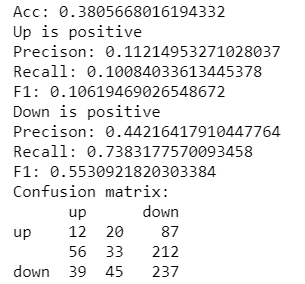
3-class with random shuffle

### RandomForestClassifier

In [ ]:
f = ObjectiveFunctionRandomForestClassifier(df_news_train, df_prices, 
                                           (lambda true, pred: precision_clf(true, pred, True)), k_folds=8)
trials = hyperopt.Trials()
parameter_space = {'max_depth':hp.quniform('max_depth',1,10,q=1),
                  'n_estimators':hp.quniform('n_estimators',10,100,q=1),
                   'min_samples_split':hp.quniform('min_samples_split',2,5,q=1),
                   'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,q=1),
                  'vector_size':hp.quniform('vector_size',1,20,q=1),
                  'window':hp.quniform('window',1,10,q=1),
                  'min_count':hp.quniform('min_count',1,10,q=1),
                  'lag':hp.quniform('lag',4*3600,10*3600,q=2*3600),
                  'window_width':hp.quniform('window_width',5,20,q=1),
                  'window_stride':hp.quniform('window_stride',1,5,q=1)}

In [ ]:
%%time
# Run TPE
best = hyperopt.fmin(f, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=25, trials=trials, verbose=1)
print("best estimate parameters", best)

In [ ]:
# Best mean score: 0.40917134449924375
# w/ random shuffle best_params_rfclf = {'lag': 36000.0, 'max_depth': 10.0, 'min_count': 2.0, 'min_samples_leaf': 4.0, 'min_samples_split': 4.0, 'n_estimators': 90.0, 'vector_size': 13.0, 'window': 6.0, 'window_stride': 4.0, 'window_width': 14.0}
est

In [ ]:
rf_clf = ClassifierRandomForestClassifier(best_params_rfclf)

In [ ]:
rf_clf.fit(df_news_train, df_prices)

In [ ]:
pred_rf_clf, true_rf_clf, prices0_rf_clf, prices1_rf_clf = rf_clf.predict(df_news_test, return_additional_data=True)

In [ ]:
summary_clf(true_rf_clf, pred_rf_clf)

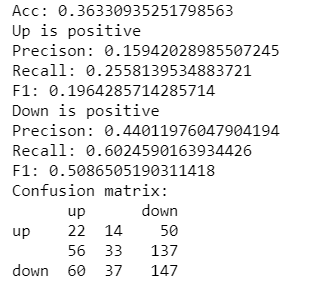
3-class with random shuffle

# Binary  classification

In [ ]:
def get_target_binary_up(prices0, prices1, threshold=0.002):
    target = prices1 / prices0 - 1
    target_class = [0 if t < threshold else 1 for t in target]
    return np.array(target_class)

def get_target_binary_down(prices0, prices1, threshold=0.002):
    target = prices1 / prices0 - 1
    target_class = [0 if t > - threshold else 1 for t in target]
    return np.array(target_class)

In [ ]:
class KfoldsCV:
    def __init__(self, estimator, d2v, df_news, df_prices, target_function, lag=6*60*60, window_width=10, window_stride=1):
        self.estimator = estimator
        self.d2v = d2v
        self.df_news = df_news
        self.df_prices = df_prices
        self.target_function = target_function
        
        self.dates0 = news_analysis.to_datetime(df_news.created_at.values)
        self.dates1 = self.dates0 + datetime.timedelta(0, lag)
        self.prices0 = news_analysis.get_prices_at_date(self.dates0, self.df_prices)
        self.prices1 = news_analysis.get_prices_at_date(self.dates1, self.df_prices)
        
        self.window_width = window_width
        self.window_stride = window_stride
        
        
    def score(self, scoring_function, k_folds=10, verbose=0, random_shuffle=False):
        '''
        scoring_function : func(y_true, y_pred) -> score
        '''
        test_sizes = np.ones(k_folds) * (self.df_news.shape[0] // k_folds) + \
            np.concatenate([np.ones(self.df_news.shape[0] % k_folds), np.zeros(k_folds - self.df_news.shape[0] % k_folds)])
        indexes = np.arange(self.df_news.shape[0])
        if random_shuffle:
            np.random.shuffle(indexes)
        
        print('Starting CV') if verbose > 0 else None 
        self.scores = []
        self.fitted_estimators = []
        for i in range(k_folds):
            test_indexes = indexes[int(test_sizes[:i].sum()): int(test_sizes[:i+1].sum())].astype(int)
            train_indexes = np.concatenate([indexes[:int(test_sizes[:i].sum())], indexes[int(test_sizes[:i+1].sum()):indexes.shape[0]]]).astype(int)
            
            embeddings_train = self.d2v.fit_transform(self.df_news.title.iloc[train_indexes].values)
            embeddings_test = self.d2v.transform(self.df_news.title.iloc[test_indexes].values)
            
            target_train = self.target_function(self.prices0[train_indexes], self.prices1[train_indexes])
            target_test = self.target_function(self.prices0[test_indexes], self.prices1[test_indexes])
            
            X_train, Y_train = make_dataset(embeddings_train, target_train, self.window_width, self.window_stride)
            X_test, Y_test = make_dataset(embeddings_test, target_test, self.window_width, self.window_stride)
            
            fitted_estimator = deepcopy(self.estimator)
            fitted_estimator.fit(X_train, Y_train)
            Y_pred = fitted_estimator.predict(X_test)
            score = scoring_function(Y_test, Y_pred)
            
            self.scores.append(score)
            self.fitted_estimators.append(fitted_estimator)
            if verbose > 0:
                print('Score {}: {}'.format(i, score))
        return self
    
    def score_parallel(self, scoring_function, k_folds=10, verbose=0, random_shuffle=False):
        '''
        scoring_function : func(y_true, y_pred) -> score
        '''
        test_sizes = np.ones(k_folds) * (self.df_news.shape[0] // k_folds) + \
            np.concatenate([np.ones(self.df_news.shape[0] % k_folds), np.zeros(k_folds - self.df_news.shape[0] % k_folds)])
        indexes = np.arange(self.df_news.shape[0])
        if random_shuffle:
            np.random.shuffle(indexes)
        
        print('Starting CV') if verbose > 0 else None 
        
        self.scores = []
        tmp = open('score_parallel.tmp', 'w')
        
        pool = Pool()
        sfs = lambda i: self._single_fold_score(i, indexes, test_sizes, deepcopy(self.d2v), self.df_news.title, 
                                          self.target_function(self.prices0, self.prices1), self.window_width, self.window_stride, 
                                          deepcopy(self.estimator), verbose, scoring_function)
        pool.map(sfs, range(k_folds))
        pool.close()
        
        tmp = open('score_parallel.tmp', 'r')
        self.scores = list(map(float, tmp.readlines()))
        tmp.close()
        return self
        
    def _single_fold_score(self, i, indexes, test_sizes, d2v, titles, target, window_width, window_stride, estimator, verbose, scoring_function):
        test_indexes = indexes[int(test_sizes[:i].sum()): int(test_sizes[:i+1].sum())].astype(int)
        train_indexes = np.concatenate([indexes[:int(test_sizes[:i].sum())], indexes[int(test_sizes[:i+1].sum()):indexes.shape[0]]]).astype(int)

        embeddings_train = d2v.fit_transform(titles.iloc[train_indexes].values)
        embeddings_test = d2v.transform(titles.iloc[test_indexes].values)

        target_train = target[train_indexes]
        target_test = target[test_indexes]

        X_train, Y_train = make_dataset(embeddings_train, target_train, window_width, window_stride)
        X_test, Y_test = make_dataset(embeddings_test, target_test, window_width, window_stride)

        estimator.fit(X_train, Y_train)
        Y_pred = estimator.predict(X_test)

#         open('score_parallel.tmp','a').write(str(scoring_function(Y_test, Y_pred)) + '\n')
        score = scoring_function(Y_test, Y_pred)
#         score = i
        open('score_parallel.tmp','a').write(str(score) + '\n')
        if verbose > 0:
                print('Score {}: {}'.format(i, score))

In [ ]:
class ObjectiveFunctionBase:
    def __init__(self, df_news, df_prices, scoring_function, target_function, k_folds=10, verbose=1, log_path=PATH_TO_DATA+'logs/', parallelize=True):
        self.df_news = df_news
        self.df_prices = df_prices
        self.scoring_function = scoring_function
        self.target_function = target_function
        self.k_folds = k_folds
        self.verbose = verbose
        self.iteration = 0
        self.log_csv = log_path + 'Base_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv'
        self.parallelize = parallelize

    def _get_estimator(self, X):
        assert True, 'Can not __call__ with _get_estimator of ObjectiveFunctionBase'
        
    def _set_log(self, log_csv):
        self.log_csv = log_csv
        
    # Calculate cross validation score (default is 10-fold CV)
    def __call__(self, X):
        self.iteration += 1
        print('Iteration:', self.iteration)
        estimator = self._get_estimator(X)
        d2v = D2Vmodel(vector_size=int(X['vector_size']), window=int(X['window']), min_count=int(X['min_count']))
        cv = KfoldsCV(estimator, d2v, self.df_news, self.df_prices, target_function=self.target_function,
                      lag=int(X['lag']), window_width=int(X['window_width']), window_stride=int(X['window_stride']))
        
        if self.parallelize:
            cv.score_parallel(self.scoring_function, k_folds=self.k_folds, verbose=self.verbose)
        else:
            cv.score(self.scoring_function, k_folds=self.k_folds, verbose=self.verbose)
        print(X)
        mean_score = np.mean(cv.scores)
        print('Mean score:', mean_score)
        print()
        if self.iteration == 1:
            df_log = pd.DataFrame(columns=list(X.keys()) + ['score'])
            df_log.to_csv(self.log_csv)
        new_row = {item[0]: item[1] for item in X.items()}
        new_row['score'] = mean_score
        df_log = pd.read_csv(self.log_csv).loc[:,list(new_row.keys())]
        df_log = df_log.append(new_row, ignore_index=True)
        df_log.to_csv(self.log_csv)
        return - mean_score    # for minimization

In [ ]:
class ObjectiveFunctionXGBClassifier(ObjectiveFunctionBase):
    def __init__(self, df_news, df_prices, scoring_function, target_function, k_folds=10, verbose=1, log_path=PATH_TO_DATA+'logs/'):
        super(ObjectiveFunctionXGBClassifier, self).__init__(df_news, df_prices, scoring_function, 
                                            k_folds, verbose)
        ObjectiveFunctionBase._set_log(self, log_path + 'XGBclf_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv')
    
    def _get_estimator(self, X):
        return XGBClassifier(max_depth=int(X['max_depth']), n_estimators=int(X['n_estimators']))
    
class ObjectiveFunctionRandomForestClassifier(ObjectiveFunctionBase):
    def __init__(self, df_news, df_prices, scoring_function, target_function, k_folds=10, verbose=1, log_path=PATH_TO_DATA+'logs/'):
        super(ObjectiveFunctionRandomForestClassifier, self).__init__(df_news, df_prices, scoring_function, 
                                            k_folds, verbose)
        ObjectiveFunctionBase._set_log(self, log_path + 'RFclf_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv')
    
    def _get_estimator(self, X):
        return RandomForestClassifier(max_depth=int(X['max_depth']), n_estimators=int(X['n_estimators']),
                                    min_samples_split=int(X['min_samples_split']), 
                                     min_samples_leaf=int(X['min_samples_leaf']))

In [ ]:
class ClassifierBase:
    def __init__(self, params, target_function):
        self.params = params
        self.estimator = self._get_estimator()
        self.d2v = D2Vmodel(vector_size=int(self.params['vector_size']), 
                            window=int(self.params['window']),
                            min_count=int(self.params['min_count']))
        self.lag = int(self.params['lag'])
        self.window_width = int(self.params['window_width'])
        self.window_stride = int(self.params['window_stride'])
        self.target_function = target_function
                                 
        
    def fit(self, df_news, df_prices):
        self.df_prices = df_prices
        dates0 = news_analysis.to_datetime(df_news.created_at.values)
        dates1 = dates0 + datetime.timedelta(0, self.lag)
        prices0 = news_analysis.get_prices_at_date(dates0, self.df_prices)
        prices1 = news_analysis.get_prices_at_date(dates1, self.df_prices)
                                 
        embeddings = self.d2v.fit_transform(df_news.title.values)
        target = self.target_function(prices0, prices1)
            
        X, Y = make_dataset(embeddings, target, self.window_width, self.window_stride)
        self.estimator.fit(X, Y)
        Y_pred = self.estimator.predict(X)
        #return score_mean(Y, Y_pred)
                                 
    def predict(self, df_news, return_additional_data=False):
        dates0 = news_analysis.to_datetime(df_news.created_at.values)
        dates1 = dates0 + datetime.timedelta(0, self.lag)   
        prices0 = news_analysis.get_prices_at_date(dates0, self.df_prices)
        prices1 = news_analysis.get_prices_at_date(dates1, self.df_prices)
               
        embeddings = self.d2v.fit_transform(df_news.title.values)
        target = self.target_function(prices0, prices1)
                
        X_test, Y_test, target_indexes = make_dataset(embeddings, target, self.window_width, self.window_stride,
                                      return_target_indexes=True)
        Y_pred = self.estimator.predict(X_test)
        if not return_additional_data:
            return Y_pred
        else:
            return Y_pred, Y_test, prices0[target_indexes], prices1[target_indexes]

In [ ]:
class ClassifierXGBClassifier(ClassifierBase):
    def _get_estimator(self):
        return XGBClassifier(max_depth=int(self.params['max_depth']), 
                            n_estimators=int(self.params['n_estimators']), 
                            n_jobs=-1)
    
class ClassifierRandomForestClassifier(ClassifierBase):
    def _get_estimator(self):
        return RandomForestClassifier(max_depth=int(self.params['max_depth']), 
                                     n_estimators=int(self.params['n_estimators']),
                                    min_samples_split=int(self.params['min_samples_split']), 
                                     min_samples_leaf=int(self.params['min_samples_leaf']), n_jobs=-1)

### XGBClassifier

In [ ]:
f = ObjectiveFunctionXGBClassifier(df_news_train, df_prices, 
                                   scoring_function=(lambda true, pred: precision_clf(true, pred, True)), 
                                   target_function=get_target_binary_down,
                                   k_folds=8)
trials = hyperopt.Trials()
parameter_space = {'max_depth':hp.quniform('max_depth',1,10,q=1),
                  'n_estimators':hp.quniform('n_estimators',10,100,q=1),
                  'vector_size':hp.quniform('vector_size',1,20,q=1),
                  'window':hp.quniform('window',1,10,q=1),
                  'min_count':hp.quniform('min_count',1,10,q=1),
                  'lag':hp.quniform('lag',4*3600,10*3600,q=2*3600),
                  'window_width':hp.quniform('window_width',5,20,q=1),
                  'window_stride':hp.quniform('window_stride',1,5,q=1)}

In [ ]:
%%time
# Run TPE
best = hyperopt.fmin(f, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=25, trials=trials, verbose=1)

print("best estimate parameters", best)

In [ ]:
# Best mean score: 
best_params_xgbclf = {'lag': 28800.0, 
                      'max_depth': 6.0, 
                      'min_count': 9.0, 
                      'n_estimators': 53.0, 
                      'vector_size': 10.0, 
                      'window': 5.0, 
                      'window_stride': 2.0, 
                      'window_width': 18.0}

xgb_clf = ClassifierXGBClassifier(best_params_xgbclf)
xgb_clf.fit(df_news_train, df_prices)
pred_xgb_clf, true_xgb_clf, prices0_xgb_clf, prices1_xgb_clf = xgb_clf.predict(df_news_test, return_additional_data=True)

summary_clf(true_xgb_clf, pred_xgb_clf)